## Make necessary imports

In [1]:
import sys
sys.path.insert(0, '../')
import time
import numpy as np
np.set_printoptions(precision=3, linewidth=200, suppress=True)
from library.datasets.cifar10 import CIFAR10
from library.plot_tools import plot_tools
from library.utils import file_utils
import tensorflow as tf
from library.tf.LinearClassifier import TFLinearClassifier

None


In [2]:
from library.hog.hog import HOG

## Select Tensorflow device

In [3]:
# from tensorflow.python.client import device_lib
# local_device_protos = device_lib.list_local_devices()
# cpu_devices = [x.name for x in local_device_protos if x.device_type == 'CPU']
# gpu_devices = [x.name for x in local_device_protos if x.device_type == 'GPU']
# print('Available CPU Devices: ', end='')
# print(cpu_devices)
# print('Available GPU Devices: ', end='')
# print(gpu_devices)
# if len(gpu_devices) == 0:
#     if len(cpu_devices) > 0:
#         device_name = '/cpu:0'
#         print('Using CPU: %s' %device_name)
#     else:
#         print('No CPU present in the system!!!')
# else:
#     device_name = '/gpu:0'
#     print('Using GPU: %s' %device_name)

In [4]:
total_time = 0

## Experiment

In [5]:
exp_no = 105
data_source = 'Website'
num_images_required = 1.0
file_no = 10

### Parameters for experiment

In [6]:
device_name = '/gpu:0'
learning_rate = 0.01
training_epochs = 1000
display_step = 1
regularize=True
regularization_const = 0.01
train_validate_split_data = None
train_validate_split = 0.9
transform=True
transform_method='StandardScaler'
learning_rate_type='constant'
init_weights='zeros'
init_bias='ones'
dataset = 'cifar10'

In [7]:
block_size = (8,8)
cell_size = (2,2)
nbins = 9

### Log directories

In [8]:
log_dir = '../logs/' + dataset + '/' + str(file_no).zfill(2) + '_tf_linear_hog/exp_no_' + str(exp_no).zfill(3) + '/'
log_file = log_dir + 'linear_classifier.ckpt'
print('Writing tensorboard logs to %s' %log_file)
print('view logs by running tensorboard: ', end='')
print('\"tensorboard --logdir=\'./%s/10_tf_linear_hog/\' --port 61111\"' %dataset)

Writing tensorboard logs to ../logs/cifar10/10_tf_linear_hog/exp_no_105/linear_classifier.ckpt
view logs by running tensorboard: "tensorboard --logdir='./cifar10/10_tf_linear_hog/' --port 61111"


## Step 1: Load CIFAR 10 Dataset

In [9]:
start = time.time()
one_hot=True
cifar10 = CIFAR10(one_hot_encode=one_hot, num_images=num_images_required, image_mode='grey',
                  train_validate_split=train_validate_split_data, endian='little')
cifar10.load_data(train=True, test=True, data_directory='./datasets/cifar10/')
end = time.time()
print('[ Step 0] Dataset loaded in %5.6f ms' %((end-start)*1000))
print('Dataset size: ' + str(cifar10.train.data.shape))
num_train_images = cifar10.train.data.shape[0]
total_time += (end-start)

Loading CIFAR 10 Dataset
MD5sum of the file: ./datasets/cifar10/cifar-10.tar.gz is verified
Loading 50000 train images
Loading CIFAR 10 Training Dataset
Reading unpicked data file: ./datasets/cifar10/cifar-10-batches/data_batch_1
Reading unpicked data file: ./datasets/cifar10/cifar-10-batches/data_batch_2
Reading unpicked data file: ./datasets/cifar10/cifar-10-batches/data_batch_3
Reading unpicked data file: ./datasets/cifar10/cifar-10-batches/data_batch_4
Reading unpicked data file: ./datasets/cifar10/cifar-10-batches/data_batch_5
Loading 10000 test images
Loading CIFAR 10 Test Dataset
Unpickling test file: ./datasets/cifar10/cifar-10-batches/test_batch
Reading unpicked test file: ./datasets/cifar10/cifar-10-batches/test_batch
Loaded CIFAR 10 Dataset in 2.2825 seconds
[ Step 0] Dataset loaded in 2283.517361 ms
Dataset size: (50000, 3072)


In [10]:
print('Train data shape:', cifar10.train.data.shape)
if one_hot is True:
    print('Train labels shape:', cifar10.train.one_hot_labels.shape)
print('Train class labels shape:', cifar10.train.class_labels.shape)
if train_validate_split_data is not None:
    print('Validate data shape:', cifar10.validate.data.shape)
    if one_hot is True:
        print('Validate labels shape:', cifar10.validate.one_hot_labels.shape)
    print('Validate class labels shape:', cifar10.validate.class_labels.shape)
print('Test data shape:', cifar10.test.data.shape)
if one_hot is True:
    print('Test labels shape:', cifar10.test.one_hot_labels.shape)
print('Test class labels shape:', cifar10.test.class_labels.shape)

Train data shape: (50000, 3072)
Train labels shape: (50000, 10)
Train class labels shape: (50000,)
Test data shape: (10000, 3072)
Test labels shape: (10000, 10)
Test class labels shape: (10000,)


In [11]:
print('Training images')
print(cifar10.train.data[:5])
if one_hot is True:
    print('Training labels')
    print(cifar10.train.one_hot_labels[:5])
print('Training classes')
print(cifar10.train.class_labels[:5])
print('Testing images')
print(cifar10.test.data[:5])
if one_hot is True:
    print('Testing labels')
    print(cifar10.test.one_hot_labels[:5])
print('Testing classes')
print(cifar10.test.class_labels[:5])

Training images
[[ 59  43  50 ..., 140  84  72]
 [154 126 105 ..., 139 142 144]
 [255 253 253 ...,  83  83  84]
 [ 28  37  38 ...,  28  37  46]
 [170 168 177 ...,  82  78  80]]
Training labels
[[ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]]
Training classes
[6 9 9 4 1]
Testing images
[[158 159 165 ..., 124 129 110]
 [235 231 232 ..., 178 191 199]
 [158 158 139 ...,   8   3   7]
 [155 167 176 ...,  50  52  50]
 [ 65  70  48 ..., 136 146 117]]
Testing labels
[[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]]
Testing classes
[3 8 8 0 6]


## Step 1.1 Load sample images

Plotting CIFAR 10 Train Dataset


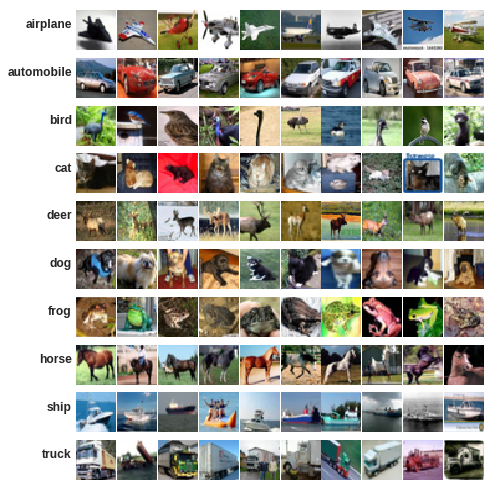

Plotting CIFAR 10 Test Dataset


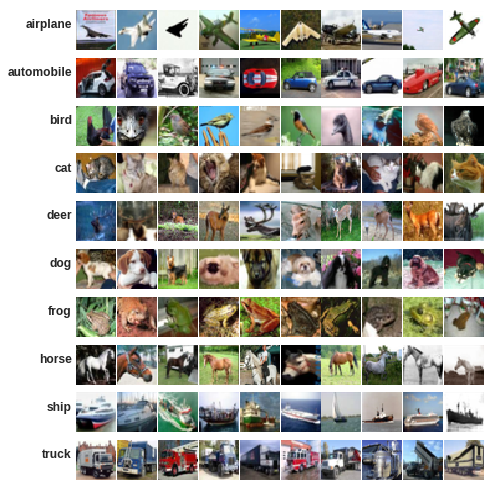

In [12]:
cifar10.plot_sample(plot_data=True, plot_test=True, fig_size=(7, 7))

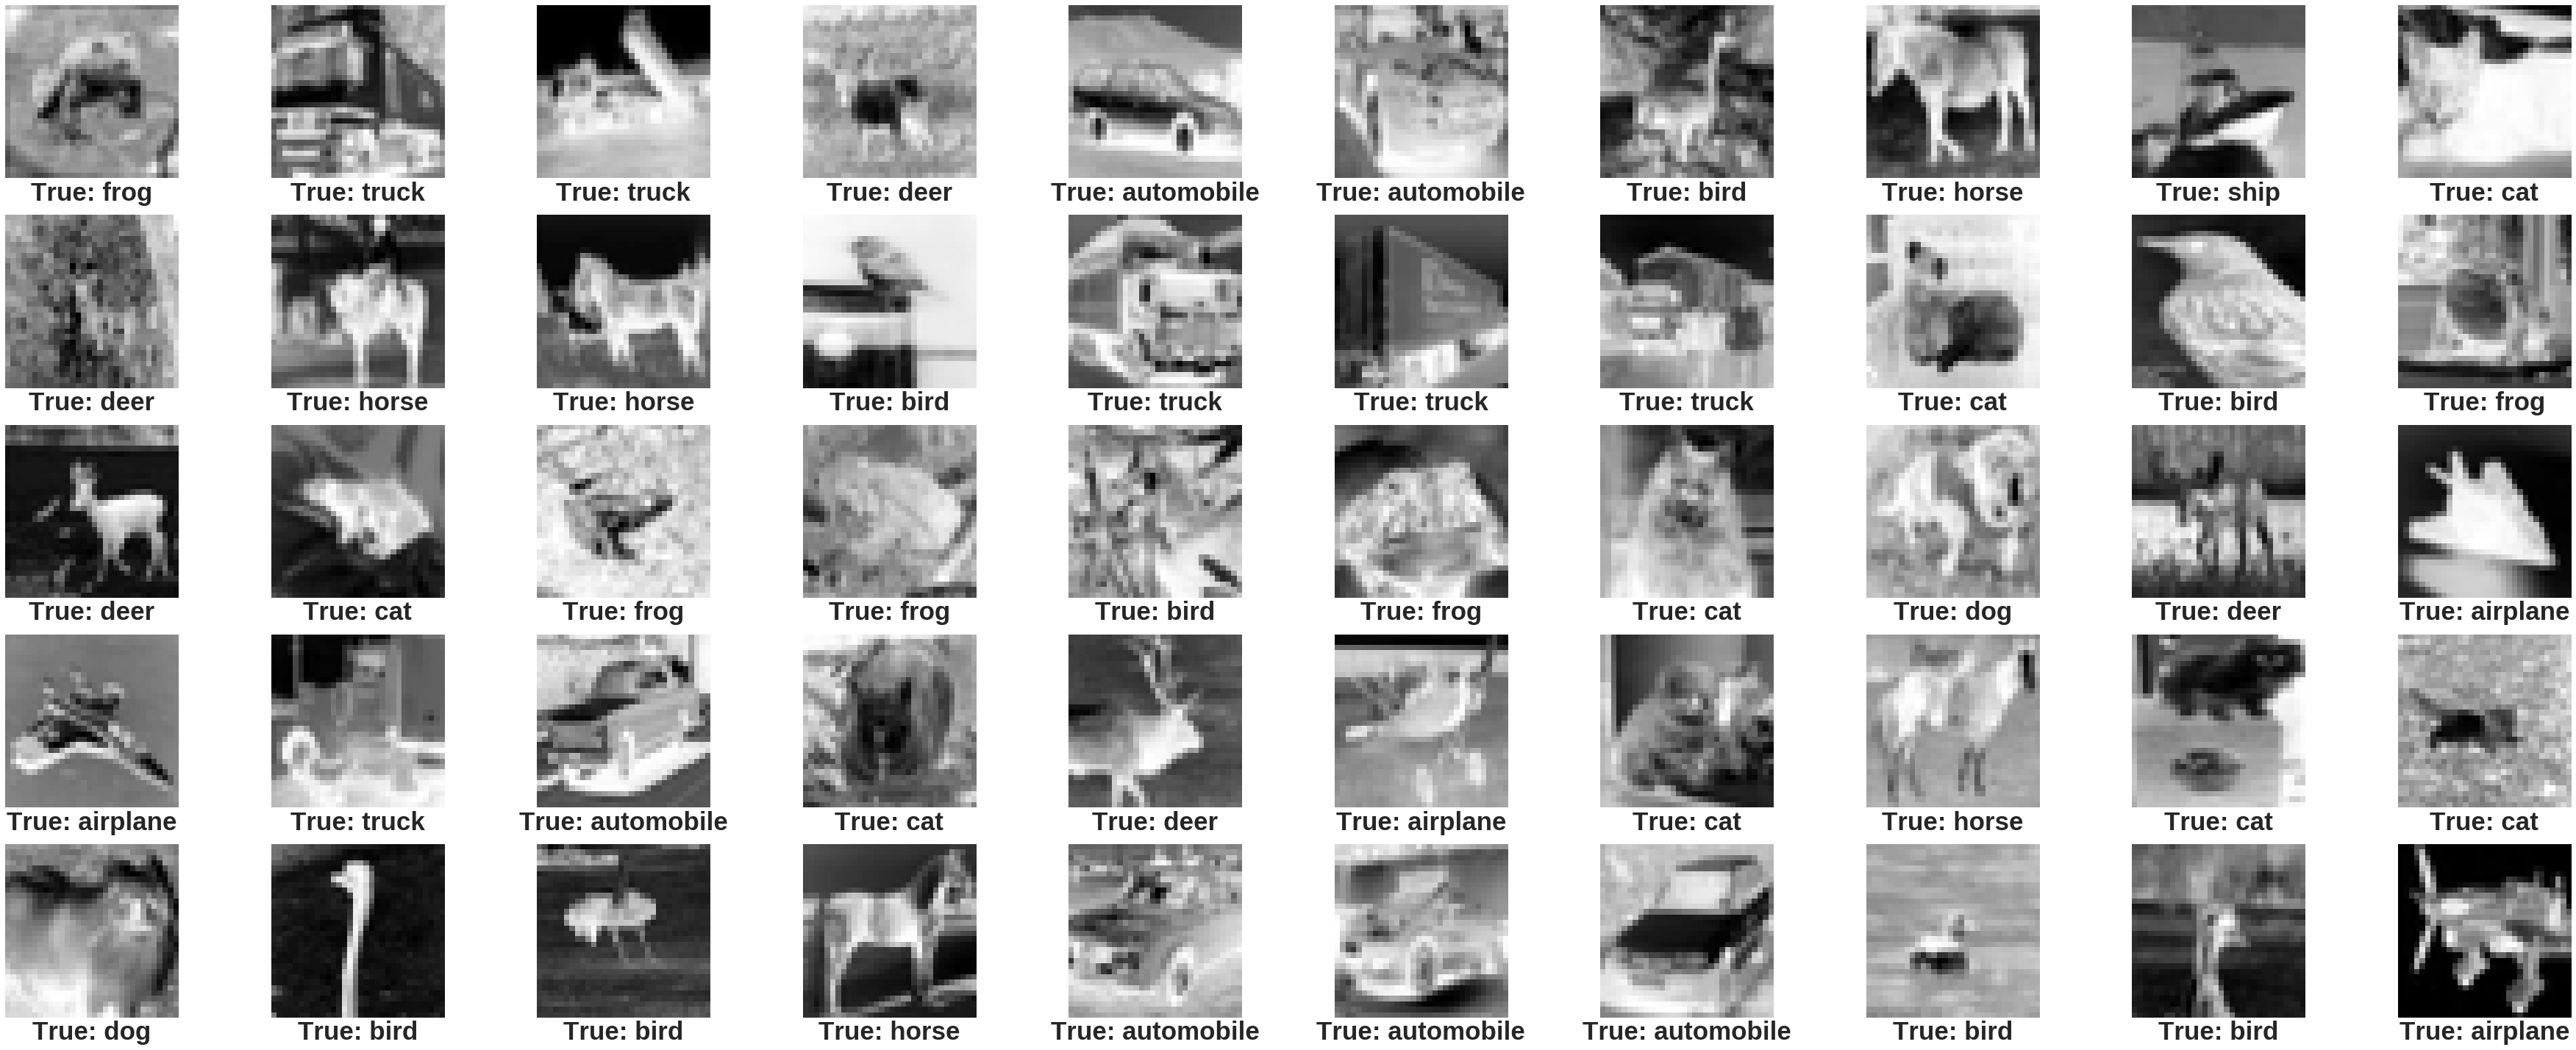

True

In [13]:
cifar10.plot_images(cifar10.train.images[:50, :], cifar10.train.class_names[:50], 
                    nrows=5, ncols=10, fig_size=(20,50), fontsize=35, convert=False)

## Step 1.1: Make CIFAR 10 HOG Train dataset

In [14]:
start = time.time()
data_hog = []
feature_size = 0
print('Block size     : ' + str(block_size))
print('Cell size      : ' + str(cell_size))
print('Number of bins : ' + str(nbins))
hog = HOG(block_size=block_size, cell_size=cell_size, nbins=nbins)
print('Generating HOG features for %d data images' %cifar10.train.images.shape[0])
for fig_num in range(cifar10.train.images.shape[0]):
    img = cifar10.train.images[fig_num, :]
    gradients = hog.make_hog_gradients(img.astype('uint8'))
    data_hog.append(gradients.flatten())
    feature_size = gradients.size
data_hog = np.array(data_hog)
print('HOG Features for data: ' + str(data_hog.shape))
end = time.time()
print('Generated HOG for train images in %.6f ms' %((end-start)*1000))

Block size     : (8, 8)
Cell size      : (2, 2)
Number of bins : 9
Generating HOG features for 50000 data images
HOG Features for data: (50000, 2304)
Generated HOG for train images in 44533.255339 ms


## Step 1.2: Make CIFAR 10 HOG Test dataset

In [15]:
start = time.time()
test_hog = []
feature_size = 0
print('Generating HOG features for %d test images' %cifar10.test.images.shape[0])
for fig_num in range(cifar10.test.images.shape[0]):
    img = cifar10.test.images[fig_num, :]
    gradients = hog.make_hog_gradients(img.astype('uint8'))
    test_hog.append(gradients.flatten())
    feature_size = gradients.size
test_hog = np.array(test_hog)
print('HOG Features for test: ' + str(test_hog.shape))
end = time.time()
print('Generated HOG for test images in %.6f ms' %((end-start)*1000))

Generating HOG features for 10000 test images
HOG Features for test: (10000, 2304)
Generated HOG for test images in 9177.517176 ms


## Step 2: Linear Regression

### Step 2.1: Model linear regression y = Wx + b

In [16]:
num_features = data_hog.shape[1]
num_classes = 10

In [17]:
tf_lc = TFLinearClassifier(verbose=True, device=device_name, session_type='interactive', learning_rate=learning_rate,
                           num_iterations=training_epochs, display_step=display_step, save_model=True, restore=False,
                           regularize=regularize, reg_const=regularization_const, train_validate_split=train_validate_split, 
                           init_weights=init_weights, init_bias=init_bias, model_name=log_file, log_dir=log_dir, 
                           learning_rate_type=learning_rate_type, test_log=True, separate_writer=False,
                           transform_method=transform_method)
print(tf_lc)

### Step 2.2: Create the tensorflow graph

In [18]:
start = time.time()
tf_lc.create_graph(num_features=num_features, num_classes=num_classes)
end = time.time()
print('Generated the tensorflow graph in %.4f ms' %((end-start)*1000))
total_time = (end-start)

Tensorflow graph created in 0.1827 seconds
Generated the tensorflow graph in 182.9076 ms


In [19]:
print(tf_lc.print_parameters())

>> Parameters for Linear Classifier
Activation function        :  softmax
Gradient Descent Method    :  gradient
Learning rate type         :  constant
Learning rate              :  0.01
Regularization constant    :  0.01
Error Tolerance            :  1e-07
Data Transformation method :  StandardScaler
Weights initializer        :  zeros
Bias initializer           :  ones
>> Inputs for Tensorflow Graph
X                          :  Tensor("Inputs/Data/X:0", shape=(?, 2304), dtype=float32, device=/device:GPU:0)
Y_true                     :  Tensor("Inputs/Train_Labels/y_label:0", shape=(?, 10), dtype=float32, device=/device:GPU:0)
Y_true_cls                 :  Tensor("Inputs/Train_Labels/y_class:0", shape=(?,), dtype=int64, device=/device:GPU:0)
Device to use              :  /gpu:0
>> Output parameters for Tensorflow Graph
Restore model              :  False
W                          :  Tensor("Parameters/Weights/W_zeros/read:0", shape=(2304, 10), dtype=float32, device=/device:GPU:0)
b 

### Step 2.3: Fit the model/training

In [20]:
tf_lc.fit(data_hog, cifar10.train.one_hot_labels, cifar10.train.class_labels,
          test_data=test_hog, test_labels=cifar10.test.one_hot_labels, test_classes=cifar10.test.class_labels)

Using GPU:  /gpu:0
Session: <tensorflow.python.client.session.InteractiveSession object at 0x7efbf3f16908>
Data shape             : (50000, 2304)
Labels shape           : (50000, 10)
Classes shape          : (50000,)
Train Data shape       : (45000, 2304)
Train Labels shape     : (45000, 10)
Train Classes shape    : (45000,)
Validate Data shape    : (5000, 2304)
Validate Labels shape  : (5000, 10)
Validate Classes shape : (5000,)
Length of train loss          : 0
Length of train accuracy      : 0
Length of validate loss       : 0
Length of validate accuracy   : 0
Length of test accuracy       : 0
Restoring training from epoch : 0
>>> Epoch [   0/1000]
train_loss: 2.3026 | train_acc: 0.0997 | val_loss: 2.1684 | val_acc: 0.3596 | test_acc: 0.3528 | Time: 1.5429 s
>>> Epoch [   1/1000]
train_loss: 2.1712 | train_acc: 0.3546 | val_loss: 2.0765 | val_acc: 0.3660 | test_acc: 0.3622 | Time: 1.2977 s
>>> Epoch [   2/1000]
train_loss: 2.0813 | train_acc: 0.3647 | val_loss: 2.0100 | val_acc: 0.3

### Step 2.4: Make the predictions

In [21]:
prediction_numbers = tf_lc.predict(test_hog)
prediction_classes = []
num_test_images = cifar10.test.data.shape[0]
for i in range(num_test_images):
    prediction_classes.append(cifar10.classes[int(prediction_numbers[i])])

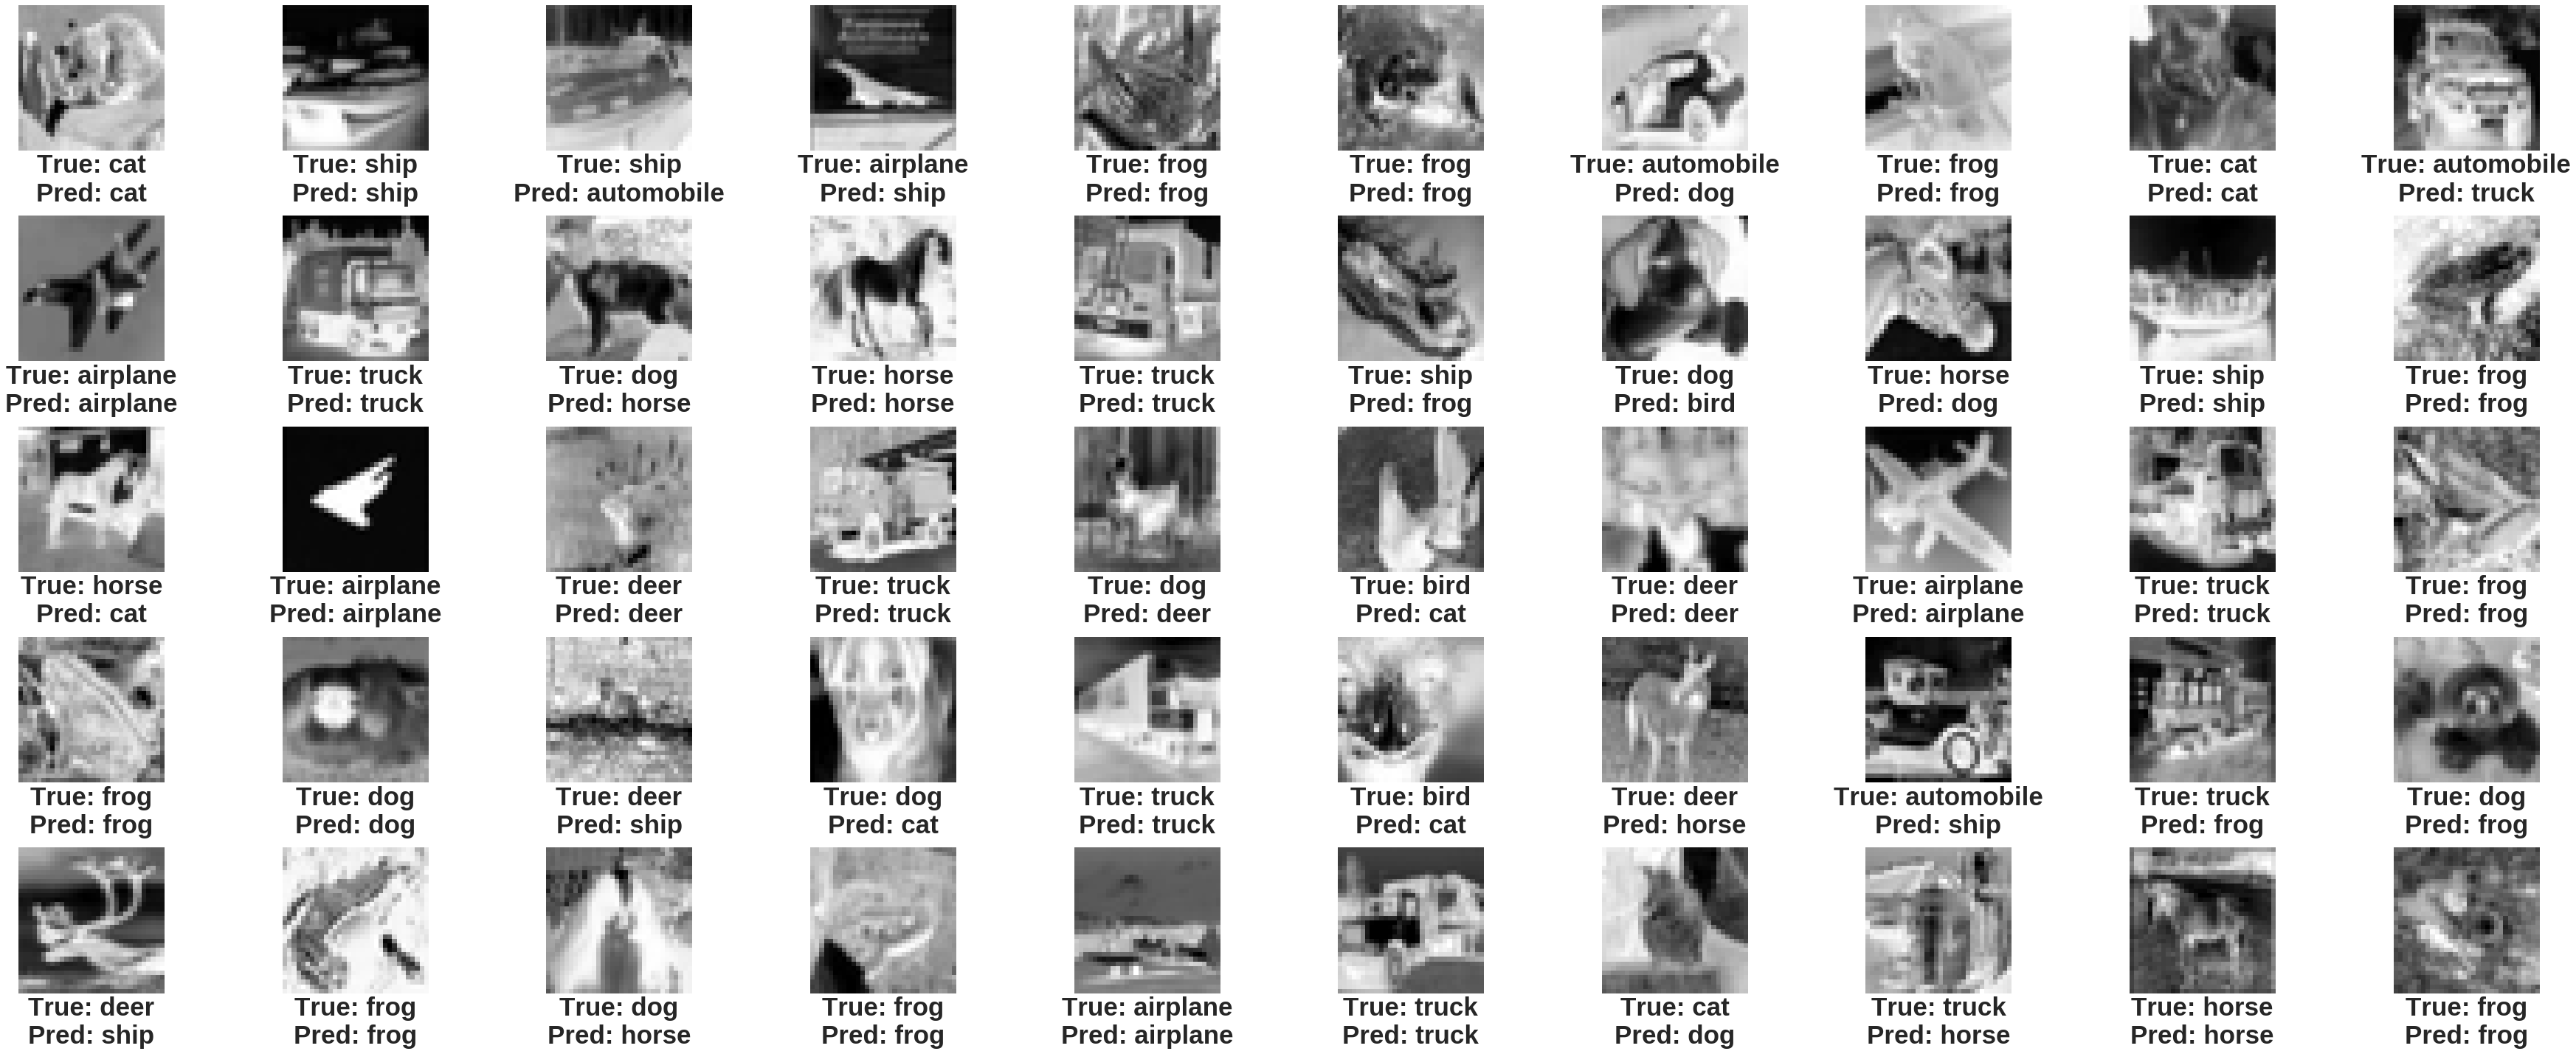

True

In [22]:
cifar10.plot_images(cifar10.test.images[:50], cifar10.test.class_names[:50], cls_pred=prediction_classes[:50], 
                    nrows=5, ncols=10, fig_size=(20,50), fontsize=35, convert=False)

### Step 2.5: Print the results

In [23]:
test_accuracy = tf_lc.print_accuracy(test_hog, cifar10.test.one_hot_labels, cifar10.test.class_labels)
print('Accuracy of the linear classifier on test dataset: %.4f' %test_accuracy)

Accuracy of the linear classifier on test dataset: 0.5125


Confusion matrix, without normalization
[[568  42  84  12  32  12  38  22 153  37]
 [ 41 634  14  11  16   8  48  18  85 125]
 [ 95  35 338  64  82 131 125  53  50  27]
 [ 47  46  70 239 102 180 144  75  35  62]
 [ 47  34  51  69 393  61 142 102  54  47]
 [ 14  23  84 134  71 416 103 106  23  26]
 [ 15  32  41  33  52  50 713  30  19  15]
 [ 32  23  53  39 100 106  44 540  18  45]
 [115 104  30   8  15   5  24  19 601  79]
 [ 29  79  13  20  22  22  19  35  78 683]]
Normalized confusion matrix
[[ 0.568  0.042  0.084  0.012  0.032  0.012  0.038  0.022  0.153  0.037]
 [ 0.041  0.634  0.014  0.011  0.016  0.008  0.048  0.018  0.085  0.125]
 [ 0.095  0.035  0.338  0.064  0.082  0.131  0.125  0.053  0.05   0.027]
 [ 0.047  0.046  0.07   0.239  0.102  0.18   0.144  0.075  0.035  0.062]
 [ 0.047  0.034  0.051  0.069  0.393  0.061  0.142  0.102  0.054  0.047]
 [ 0.014  0.023  0.084  0.134  0.071  0.416  0.103  0.106  0.023  0.026]
 [ 0.015  0.032  0.041  0.033  0.052  0.05   0.713  0.03   0.01

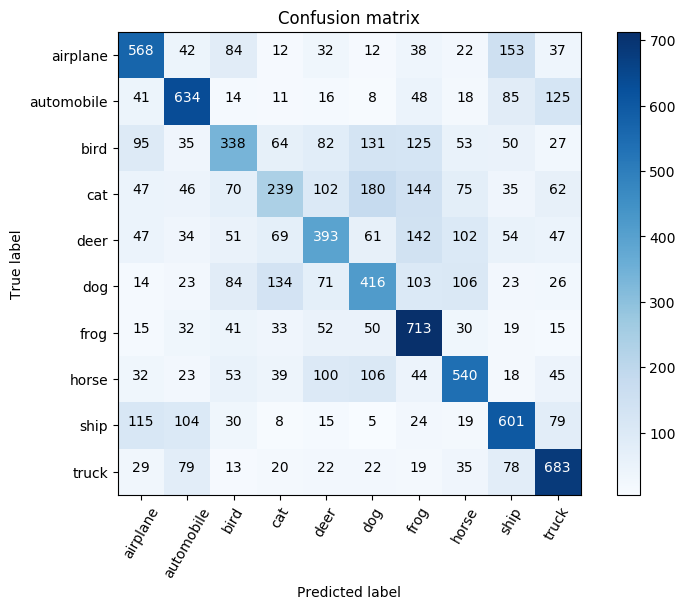

Detailed classification report
             precision    recall  f1-score   support

   airplane       0.57      0.57      0.57      1000
 automobile       0.60      0.63      0.62      1000
       bird       0.43      0.34      0.38      1000
        cat       0.38      0.24      0.29      1000
       deer       0.44      0.39      0.42      1000
        dog       0.42      0.42      0.42      1000
       frog       0.51      0.71      0.59      1000
      horse       0.54      0.54      0.54      1000
       ship       0.54      0.60      0.57      1000
      truck       0.60      0.68      0.64      1000

avg / total       0.50      0.51      0.50     10000



In [24]:
tf_lc.print_classification_results(test_hog, cifar10.test.one_hot_labels, cifar10.test.class_labels,
                                   test_class_names=cifar10.classes, normalize=True)

### Step 2.5: Close the session

In [25]:
tf_lc.close()

## Step 3: Write to file

In [26]:
def output_HTML(read_file, output_file):
    from nbconvert import HTMLExporter
    import codecs
    import nbformat
    exporter = HTMLExporter()
    output_notebook = nbformat.read(read_file, as_version=4)
    print()
    output, resources = exporter.from_notebook_node(output_notebook)
    codecs.open(output_file, 'w', encoding='utf-8').write(output)

In [27]:
%%javascript
var notebook = IPython.notebook
notebook.save_notebook()

<IPython.core.display.Javascript object>

In [30]:
%%javascript
var kernel = IPython.notebook.kernel;
var thename = window.document.getElementById("notebook_name").innerHTML;
var command = "theNotebook = " + "'"+thename+"'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [31]:
current_file = './' + theNotebook + '.ipynb'
output_file = log_dir + str(file_no).zfill(2) + '_exp_no_' + str(exp_no).zfill(3) + '_' + theNotebook + '.html'
print('Current file: ' + str(current_file))
print('Output file: ' + str(output_file))
file_utils.mkdir_p(log_dir) 
output_HTML(current_file, output_file)

Current file: ./10_Tensorflow_Linear_Classifier_HOG_features_CIFAR_10_Website.ipynb
Output file: ../logs/cifar10/10_tf_linear_hog/exp_no_105/10_exp_no_105_10_Tensorflow_Linear_Classifier_HOG_features_CIFAR_10_Website.html

